# Quant-Data project
### Hadil Ben Selma


### 1- Imports

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from toolkit.tools import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import copy
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


### 2- Loading and preparing data

In [77]:
data= pd.read_excel('C:/Users/MSI/Desktop/RAMIFY/ResearchDatasetV2.0.xlsx')
df=data.copy()
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.sort_values(by='Date', inplace=True)
df=df.set_index('Date')

In [78]:
print('The number of missing data per column is :')
df.isna().sum()

The number of missing data per column is :


Signal        0
ClosePrice    0
dtype: int64

In [79]:
a=df.index.to_series().diff().dt.days.mean()
if a<5:
    frequency='Daily'
elif a<7:
    frequency='Weekly'
elif a<40:
    frequency='Monthly'
else:
    frequency='Quarterly'

print(f"Calculated Common Frequency: {frequency} with frequency mean {a}")

Calculated Common Frequency: Daily with frequency mean 1.454954954954955


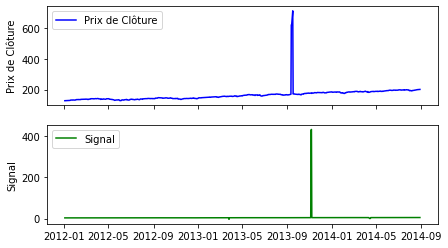

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  figsize=(7, 2*len(df.columns)))
# First Subplot for ClosePrice
ax1.plot(df.index, df['ClosePrice'], label='Prix de Clôture', color='blue')
ax1.set_ylabel('Prix de Clôture')
ax1.legend(loc='upper left')
#Second subplot for Signal
ax2.plot(df.index, df['Signal'], label='Signal', color='green')
ax2.set_ylabel('Signal')
ax2.legend(loc='upper left')

### 3- Data Cleaning and outliers detection

##### **3.1 -Outliers detection**

- Detection of outliers using a rolling window of one trading month
We marking as outliers data points that are outside the interval [$ \mu - 3\sigma, \mu + 3\sigma$].

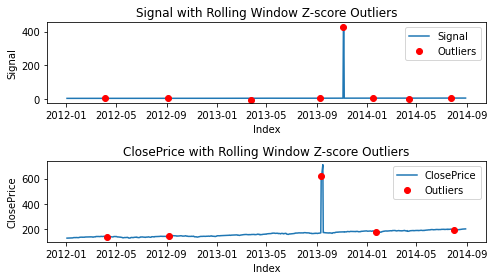

In [81]:
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(7, 2*len(df.columns)))
for i, col in enumerate(df.columns):
    # Create a subplot for the current column
    ax = axes[i]
    # 'detect_and_plot_outliers' is a function defined in tools to detect and plot outliers.
    detect_and_plot_outliers_zscore(df, col, ax,20, True,3)
# Adjust the layout of the subplots to prevent overlapping.
plt.tight_layout()
plt.show()

- Detection of outliers using the inter-quantile method

we mark data points as outliers on a plot if they fall outside 1.5 times the interquartile range from the first to the third quartiles.

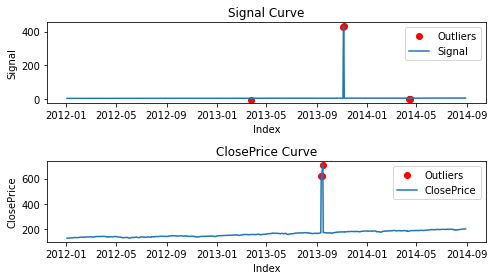

In [82]:
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(7, 2*len(df.columns)))
for i, col in enumerate(df.columns):
    # Create a subplot for the current column
    ax = axes[i]
    # 'detect_and_plot_outliers' is a function defined in tools to detect and plot outliers.
    outliers,lower_bound,upper_bound=detect_and_plot_outliers(df, col, ax, True)
# Adjust the layout of the subplots to prevent overlapping.
plt.tight_layout()
plt.show()

We have presented the earlier plots where we highlighted outliers identified by the 'detect_and_plot_outliers_zscore' and 'detect_and_plot_outliers' functions, defined in our tools module. 
Upon comparing two methods for outlier detection—the interquartile range (IQR) and the z-score—we found that the z-score approach tends to flag more data points as outliers . 
This is possibly because it is more sensitive to skew and kurtosis. 
Given this tendency, **we chose the IQR method**, which we believe more accurately discriminates between typical data variations and true outliers.

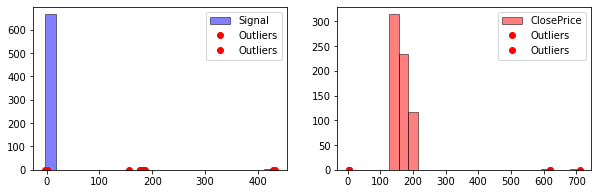

1.9327366504854244 5.893658980582426 79.94999999999999 242.43


In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# Plot histograms for 'Signal' and 'ClosePrice' with labels, adding bin separation
h1 = ax1.hist(df['Signal'], bins=20, color='b', alpha=0.5, label='Signal', edgecolor='k')
h2 = ax2.hist(df['ClosePrice'], bins=20, color='r', alpha=0.5, label='ClosePrice', edgecolor='k')
# Function to detect outliers and mark them in red on the histogram
outliers_signal,lower_bound,upper_bound = detect_and_plot_outliers(df, 'Signal', None, False)
outliers_price,lower_bound_p,upper_bound_p = detect_and_plot_outliers(df, 'ClosePrice', None, False)
ax1.plot(outliers_signal, [0] * len(outliers_signal), 'ro', label='Outliers')
ax2.plot(outliers_price, [0] * len(outliers_price), 'ro', label='Outliers')
# Add legends to histograms
ax1.legend()
ax2.legend()
# Display the figure
plt.show()
print(lower_bound,upper_bound,lower_bound_p,upper_bound_p)


We remove the detected outliers from data and we show the same histograms as above.

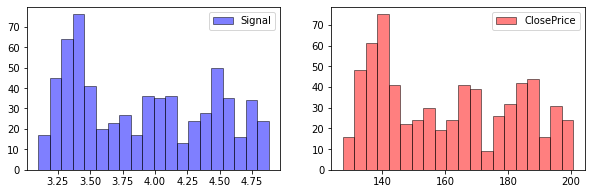

In [84]:
# Filter the data to exclude outliers
filtered_df = filter_outliers(df, 'Signal')
filtered_df2 = filter_outliers(df, 'ClosePrice')
# Create a figure with two subplots for the histograms
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
# Plot histograms for filtered data with labels
h1 = ax1.hist(filtered_df['Signal'], bins=20, color='b', alpha=0.5, label='Signal', edgecolor='k')
h2 = ax2.hist(filtered_df2['ClosePrice'], bins=20, color='r', alpha=0.5, label='ClosePrice', edgecolor='k')
# Add legends to histograms
ax1.legend()
ax2.legend()
plt.show()

=> The outliers detected are very extreme values and should be updated or removed.

In [85]:
outliers_signal,lower_bound,upper_bound=detect_and_plot_outliers(df, 'Signal', None,False)
outliers_price,lower_bound_p,upper_bound_p=detect_and_plot_outliers(df, 'ClosePrice', None,False)
print('outliers of close price :\n ',outliers_price,'\n with upper bound ',upper_bound_p,' and lower bound ',lower_bound_p,'\n ')
print('outliers of signal : \n',outliers_signal,'\n with upper bound ',upper_bound,' and lower bound ',lower_bound,'\n ')

outliers of close price :
                Signal  ClosePrice
Date                            
2013-09-12  4.193204      618.95
2013-09-13  4.143689      619.33
2013-09-16  4.124515      710.31 
 with upper bound  242.43  and lower bound  79.94999999999999 
 
outliers of signal : 
                 Signal  ClosePrice
Date                              
2013-03-26   -3.802670    156.1900
2013-11-05  429.514563    176.2700
2013-11-06  432.961165    177.1700
2014-04-14    0.004560    182.9401
2014-04-15    0.454976    184.2000
2014-04-16    0.455898    186.1250 
 with upper bound  5.893658980582426  and lower bound  1.9327366504854244 
 


##### **3.2- Replacement of outliers using an iterative imputer with XGBRegressor**

In [86]:
df_no_outliers = df.copy()
# Replace outliers with NaN values
df_no_outliers.loc[outliers_signal.index, 'Signal'] = None
df_no_outliers.loc[outliers_price.index, 'ClosePrice'] = None
# Use XGBoost as a model for iterative imputation
xgb_regressor = XGBRegressor()
imputer = IterativeImputer(estimator=xgb_regressor, max_iter=10, random_state=0)
df_imputed = imputer.fit_transform(df_no_outliers)
# Replace columns in the original dataset with the imputed values
df['Signal'] = df_imputed[:,0]
df['ClosePrice'] = df_imputed[:,1]

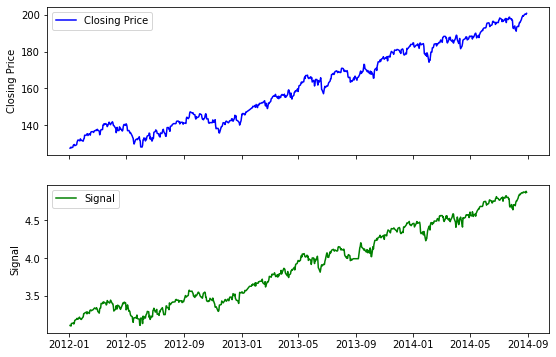

In [87]:
# Create a figure with three subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 6))
# First subplot for the closing price
ax1.plot(df.index, df['ClosePrice'], label='Closing Price', color='blue')
ax1.set_ylabel('Closing Price')
ax1.legend(loc='upper left')
# Second subplot for the signal
ax2.plot(df.index, df['Signal'], label='Signal', color='green')
ax2.set_ylabel('Signal')
ax2.legend(loc='upper left')


### 4- Data analysis

- **4.1 - Caculation of return and log_return the ClosePrice of S&P and their cumulative values**

In [88]:
# Calculation of simple returns for ClosePrice
df['Cumulative_Return'] = (df['ClosePrice'].pct_change()).cumsum()
# Calculation of simple returns for Signal
df['Return'] = df['ClosePrice'].pct_change()
# Calculation of logarithmic returns for ClosePrice
df['Cumulative_Log_Return'] = (np.log(df['ClosePrice'] / df['ClosePrice'].shift(1))).cumsum()
# Calculation of logarithmic returns for Signal
df['Log_Return'] = np.log(df['Signal'] / df['Signal'].shift(1))
df = df.dropna() # Drop rows with NaN values

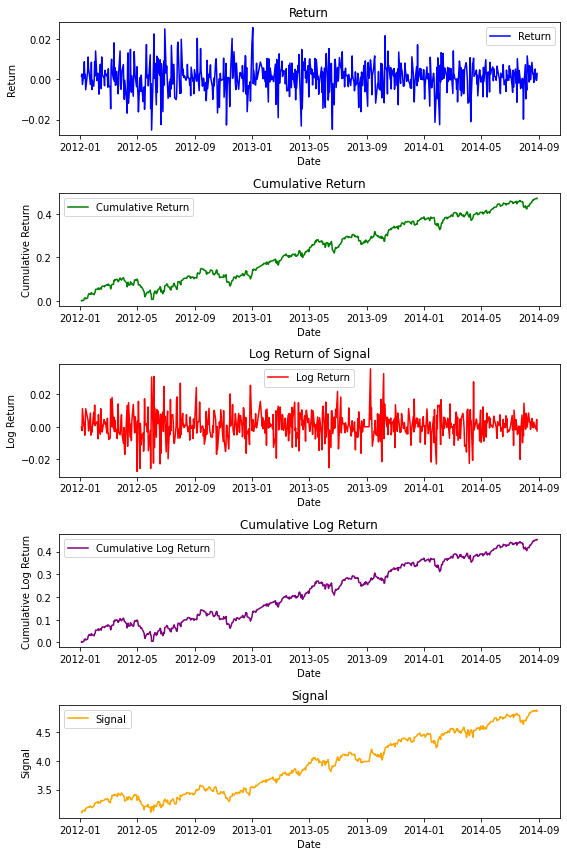

In [89]:
# Plot each of the metrics in a separate subplot
fig, axs = plt.subplots(5, 1, figsize=(8, 12))  # Adjust the size as needed
# Plot Return
axs[0].plot(df.index, df['Return'], label='Return', color='blue')
axs[0].set_title('Return')
axs[0].set_ylabel('Return')
axs[0].legend()
# Plot Cumulative Return
axs[1].plot(df.index, df['Cumulative_Return'], label='Cumulative Return', color='green')
axs[1].set_title('Cumulative Return')
axs[1].set_ylabel('Cumulative Return')
axs[1].legend()
# Plot Log Return
axs[2].plot(df.index, df['Log_Return'], label='Log Return', color='red')
axs[2].set_title('Log Return of Signal')
axs[2].set_ylabel('Log Return')
axs[2].legend()
# Plot Cumulative Log Return
axs[3].plot(df.index, df['Cumulative_Log_Return'], label='Cumulative Log Return', color='purple')
axs[3].set_title('Cumulative Log Return')
axs[3].set_ylabel('Cumulative Log Return')
axs[3].legend()
# Plot Signal
axs[4].plot(df.index, df['Signal'], label='Signal', color='orange')
axs[4].set_title('Signal')
axs[4].set_ylabel('Signal')
axs[4].legend()
# Set common xlabel
for ax in axs:
    ax.set_xlabel('Date')
plt.tight_layout() 
plt.show()

- **4.2 - Comparison of signal and returns**

In [90]:
correlation = df['Cumulative_Return'].corr(df['Signal'])
print("The correlation between the cumulative returns of ClosePrice and Signal is: ", correlation)
correlation = df['Cumulative_Log_Return'].corr(df['Signal'])
print("The correlation between the cumulative logarithmic returns of ClosePrice and Signal is: ", correlation)
correlation = df['Return'].corr(df['Signal'])
print("The correlation between the returns of ClosePrice and Signal is: ", correlation)
correlation = df['Log_Return'].corr(df['Signal'])
print("The correlation between the logarithmic returns of ClosePrice and Signal is: ", correlation)


The correlation between the cumulative returns of ClosePrice and Signal is:  0.9938662458853461
The correlation between the cumulative logarithmic returns of ClosePrice and Signal is:  0.9938646300981259
The correlation between the returns of ClosePrice and Signal is:  0.019350968218005655
The correlation between the logarithmic returns of ClosePrice and Signal is:  0.030505316978109584


=> We observe that the signal aligns more closely with cumulative returns rather than simple returns.

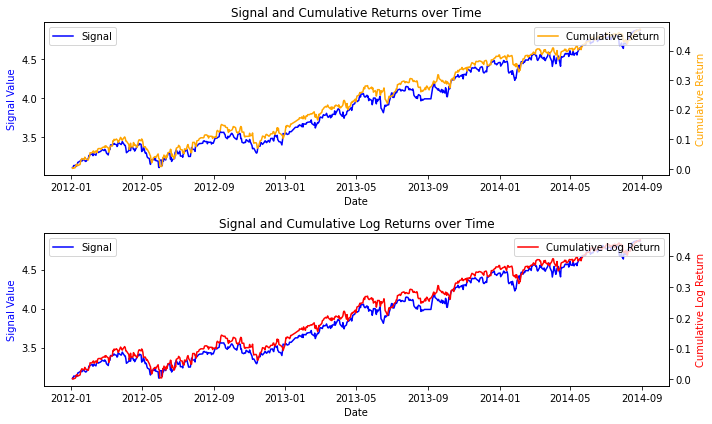

In [91]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
# First subplot: Signal and Cumulative Return
ax1 = axs[0]
ax2 = ax1.twinx()  # Create a twin of Axes for the secondary y-axis
ax1.plot(df.index, df['Signal'], label='Signal', color='blue')
ax2.plot(df.index, df['Cumulative_Return'], label='Cumulative Return', color='orange')
ax1.set_title('Signal and Cumulative Returns over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Signal Value', color='blue')
ax2.set_ylabel('Cumulative Return', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Second subplot: Signal and Cumulative Log Return
ax3 = axs[1]
ax4 = ax3.twinx()  # Create a twin for the secondary y-axis
ax3.plot(df.index, df['Signal'], label='Signal', color='blue')
ax4.plot(df.index, df['Cumulative_Log_Return'], label='Cumulative Log Return', color='red')
ax3.set_title('Signal and Cumulative Log Returns over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Signal Value', color='blue')
ax4.set_ylabel('Cumulative Log Return', color='red')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
plt.tight_layout() 
plt.show()

=> It is observable that the signal lags behind the returns.
=> Given that the correlation between the signal and cumulative logarithmic returns is a little bit higher than that between the signal and cumulative returns, we have decided to proceed with the analysis using cumulative logarithmic returns.

- **4.3 - Introduction of a delay** 

Maximum correlation is 0.9961990140320757 at a delay of 3 days.
Previous correlation is 0.9938646300981259.


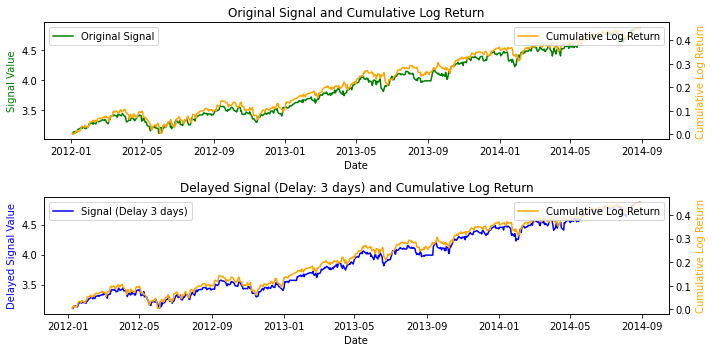

In [92]:
# Dictionary to store correlation for each delay
correlations = {}
for i in range(0, 90, 1):
    delayed_signal = df['Signal'].shift(i).dropna()  # Delayed signal
    log_return = df['Cumulative_Log_Return'].reindex(delayed_signal.index)  # Align lengths of both series
    correlation = log_return.corr(delayed_signal)  # Calculate and store correlation
    correlations[i] = correlation
# Find the delay with the maximum correlation
max_correlation = max(correlations.values())
max_delay = [delay for delay, corr in correlations.items() if corr == max_correlation][0]
print(f"Maximum correlation is {max_correlation} at a delay of {max_delay} days.")
print(f"Previous correlation is {correlations[0]}.")

# Delay the signal by the max_delay found
delayed_signal = df['Signal'].shift(max_delay).dropna()
# Align the lengths of both series by reindexing
cumulative_log_return_aligned = df['Cumulative_Log_Return'].reindex(delayed_signal.index)
# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
# First subplot: Original Signal and Cumulative Log Return
# Create a twin Axes sharing the x-axis for the first subplot
ax1_twin = ax1.twinx()
ax1.plot(df.index, df['Signal'], label='Original Signal', color='green')
ax1_twin.plot(df.index, df['Cumulative_Log_Return'], label='Cumulative Log Return', color='orange')
# Set titles and labels for the first subplot
ax1.set_title('Original Signal and Cumulative Log Return')
ax1.set_xlabel('Date')
ax1.set_ylabel('Signal Value', color='green')
ax1_twin.set_ylabel('Cumulative Log Return', color='orange')
# Add legends for the first subplot
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
# Second subplot: Delayed Signal and Cumulative Log Return
# Create a twin Axes sharing the x-axis for the second subplot
ax2_twin = ax2.twinx()
ax2.plot(df.index[max_delay:], delayed_signal, label=f'Signal (Delay {max_delay} days)', color='blue')
ax2_twin.plot(df.index[max_delay:], cumulative_log_return_aligned, label='Cumulative Log Return', color='orange')
# Set titles and labels for the second subplot
ax2.set_title(f'Delayed Signal (Delay: {max_delay} days) and Cumulative Log Return')
ax2.set_xlabel('Date')
ax2.set_ylabel('Delayed Signal Value', color='blue')
ax2_twin.set_ylabel('Cumulative Log Return', color='orange')
# Add legends for the second subplot
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

=> We found the the best delay giving the most correlated shifted signal with the cumulative log return is 3-days delay.

### 5- Predictive power of signal analysis

- **5.1 - Ordinary Least Squares regression**

We perform a regression analysis through the Ordinary Least Squares (OLS) regression. The OLS method is used to estimate the linear relationship between the delayed signal and the cumulative log returns.

In [93]:
X_train,X_test,y_train,y_test=regression_data(df,'Signal','Cumulative_Log_Return',0.2,[3])
model = sm.OLS(y_train, X_train).fit()
# Print out the statistics
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Cumulative_Log_Return   R-squared:                       0.990
Model:                               OLS   Adj. R-squared:                  0.990
Method:                    Least Squares   F-statistic:                 5.305e+04
Date:                   Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                           19:09:10   Log-Likelihood:                 1658.6
No. Observations:                    530   AIC:                            -3313.
Df Residuals:                        528   BIC:                            -3305.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7964 

**The regression results indicate a very strong relationship between the lagged signal and cumulative log returns, with an R-squared of 0.990.** This suggests that the model explains 99% of the variance in cumulative log returns.

**Dependent Variable:** The model predicts the 'Cumulative_Log_Return'.
- **<u>R-squared:</u>** The R² value is extremely high at 0.990, which indicates that the model explains 99% of the variability in the cumulative log returns. However, in financial data, a high R² should be viewed with skepticism as it may suggest a risk of overfitting, especially if the data is not out-of-sample.
- **<u>Adjusted R-squared:</u>** Similarly, the adjusted R² is 0.990, confirming that the model explains nearly all the variability in the cumulative log returns after adjusting for the number of predictors.
- **<u>F-statistic:</u>** The F-statistic is very large, suggesting that the model is statistically significant.
- **<u>Prob (F-statistic):</u>** The probability of the F-statistic is essentially 0, indicating that the model's explanatory power is statistically significant and the observed relationship is highly unlikely to be due to chance.
- **<u>Coefficients:</u>**
  - The constant term is -0.7964, with a very small standard error, indicating the model predicts a negative cumulative log return when the lagged signal is zero.
  - The coefficient for the 'Lagged_Signal' is 0.2620, which implies that for each unit increase in the lagged signal, there is a corresponding increase of 0.2613 units in the cumulative log return. This coefficient is also highly significant (p-value nearly 0).
- **<u>Standard Error:</u>** The standard errors of the coefficients are small, which indicates a high level of precision in the coefficient estimates.
- **<u>t-statistics:</u>** The t-values for both constants and lagged signal are far beyond the typical thresholds for statistical significance, reinforcing the significance of these coefficients.
- **<u>P>|t|:</u>** The p-values for both coefficients are 0.000, denoting that both the constant term and the lagged signal are statistically significant predictors of cumulative log returns.
- **<u>Confidence Interval:</u>** The 95% confidence intervals for both coefficients are tight and do not include 0, which reinforces the significance of the estimates.

**<u>Diagnostics:</u>**
- **<u>Omnibus/Prob(Omnibus):</u>** The Omnibus test is significant, suggesting that the residuals are not normally distributed. This could be a cause for concern as it violates one of the OLS assumptions.
- **<u>Skew:</u>** A skewness near 0 indicates that the residuals are symmetrically distributed, although the significance of the Omnibus test suggests this might not be the case.
- **<u>Kurtosis:</u>** A kurtosis greater than 3 suggests that the tails are heavier than a normal distribution, which implies the potential presence of outliers or extreme values.
- **<u>Durbin-Watson:</u>** The Durbin-Watson statistic is close to 1, suggesting that there is neither strong positive nor negative serial correlation in the residuals.
- **<u>Jarque-Bera (JB)/Prob(JB):</u>** The Jarque-Bera test is also significant, supporting the Omnibus test's indication that the residuals are not normally distributed.

=> In summary, while the model appears to have strong predictive power, the diagnostic tests raise concerns about the normality of the residuals, which could affect the reliability of the standard errors and thus the confidence intervals and hypothesis tests. Caution should be exercised when interpreting these results, and additional diagnostics or out-of-sample testing may be warranted to confirm the model's validity.



##### Out-of-sample testing

Root Mean Squared Error (RMSE): 0.019592400276173916
Coefficient of Variation of RMSE (CV(RMSE)): 0.04820845351464701

Mean Absolute Error (MAE): 0.01755836347942141
Coefficient of Variation of mae: 0.04320356554884878

R^2 Score: 0.4384769538621095


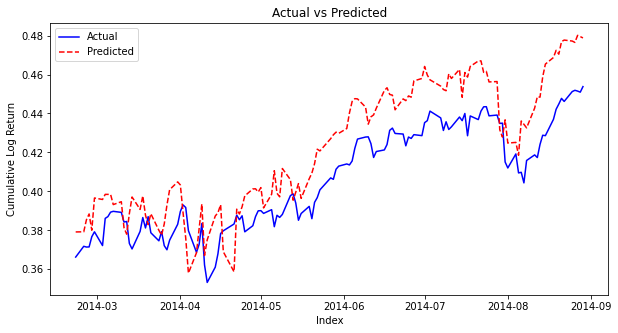

In [94]:
#Make Predictions
predictions = model.predict(X_test)
# Evaluate the Model
# Root Mean Squared Error (RMSE)
mse=mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
cv_rmse = rmse / np.mean(y_test)
print(f"Coefficient of Variation of RMSE (CV(RMSE)): {cv_rmse}\n")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Coefficient of Variation of mae: {mae/(np.mean(y_test))}\n")

# R^2 Score
r2 = r2_score(y_test, predictions)
print(f"R^2 Score: {r2}")
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
# Plot the predicted values
plt.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--')
# Adding title and labels
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Cumulative Log Return')
plt.legend()
# Show the plot
#print(np.mean(predictions),np.mean(y_test))
plt.show()


Interpretation of how the predictive signal for returns is behaving:

1. **Tracking Ability**: The model seems capable of tracking the actual returns to a certain extent. The overall direction of the actual cumulative log returns is mirrored by the predictions, which suggests the model has learned some of the underlying patterns or trends in the data.

2. **Lag**: The predicted values (red dashed line) occasionally lead or lag behind the actual values (blue solid line).

3. **Volatility**: There are points where the predicted line does not capture sharp rises or drops in the actual returns. The model's predictions seem smoother than the actual returns, which suggests it may not fully capture the volatility in the data.


5. **Error Magnitude**: During certain periods, such as the middle of the graph, the deviation between actual and predicted values grows larger, which would indicate a larger error in the model's predictions.

6. **Overall Fit**: The R-squared value (0.4384769538621095) indicates that nearly 43.4% of the variability in the cumulative log returns can be explained by the model. This is a moderate level of explanation, which suggests that while the model has predictive power, there is still a substantial amount of variability that it does not capture.


##### Trial of different shifted signals combinations

In [95]:
max_correlation = sorted(list(correlations.values()), reverse=True)[:4]

# To find the corresponding delays for these top correlations:
max_delay = [delay for delay, corr in correlations.items() if corr in max_correlation]

print("Delays of most correlated shifted signals : ", max_delay)


Delays of most correlated shifted signals :  [2, 3, 4, 5]


In [96]:
import itertools
# Generate all possible combinations of different lengths and convert them to lists of lists
all_combinations = []
for r in range(1, len(max_delay) + 1):
    combinations_object = itertools.combinations(max_delay, r)
    combinations_list = [list(comb) for comb in combinations_object]  # Convert each combination to a list
    all_combinations.extend(combinations_list)  # Add the lists to the all_combinations list
print('All possible combinaitions of delays : ',all_combinations)

All possible combinaitions of delays :  [[2], [3], [4], [5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5], [2, 3, 4], [2, 3, 5], [2, 4, 5], [3, 4, 5], [2, 3, 4, 5]]


Combinations sorted by their R2 scores:  [((5,), 0.5216522802264594), ((4, 5), 0.5038528780779576), ((3, 4, 5), 0.4843250804689908), ((3, 5), 0.48412612898670593), ((4,), 0.48050889574096767), ((3, 4), 0.46394779734528147), ((2, 3, 4, 5), 0.4534285283039594), ((2, 3, 5), 0.4529343680083022), ((2, 4, 5), 0.45210246265699094), ((2, 5), 0.44982113412382085), ((3,), 0.4384769538621095), ((2, 3, 4), 0.436078241139663), ((2, 4), 0.43474402338673646), ((2, 3), 0.41262325631543806), ((2,), 0.37609391253639435)]


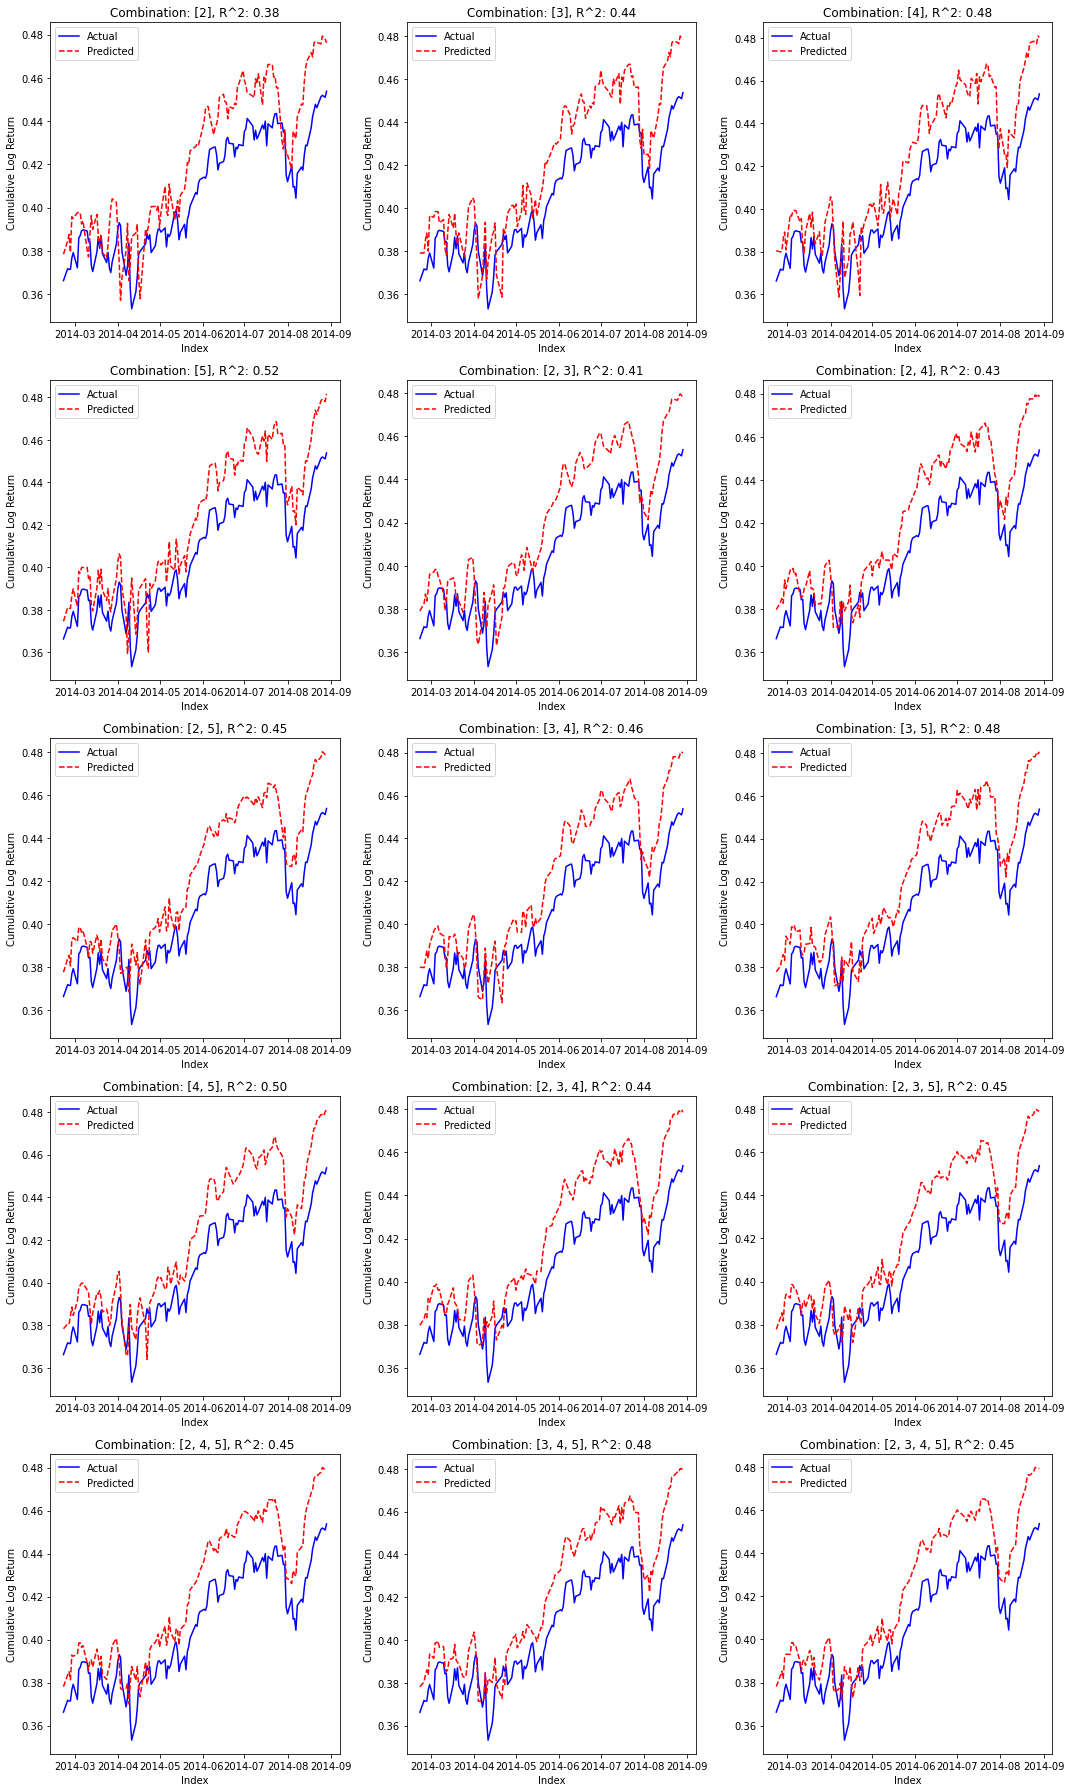

In [97]:
n_combinations = len(all_combinations)
n_cols = 3  # you can adjust this to your preferred number of columns
n_rows = (n_combinations + n_cols - 1) // n_cols  # calculate rows needed

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
axes = axes.flatten()  # flatten the axes array for easy iteration
d={}
for idx, combination in enumerate(all_combinations):
    X_train, X_test, y_train, y_test = regression_data(df, 'Signal', 'Cumulative_Log_Return', 0.2, combination)
    model = sm.OLS(y_train, X_train).fit()
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    d[tuple(combination)]=r2
    # Plot actual vs predicted values
    ax = axes[idx]
    ax.plot(y_test.index, y_test, label='Actual', color='blue')
    ax.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--')
    
    # Title with R^2 score
    ax.set_title(f'Combination: {combination}, R^2: {r2:.2f}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Cumulative Log Return')
    ax.legend()

# Hide any remaining unused subplots
for ax in axes[n_combinations:]:
    ax.set_visible(False)

# Sort the dictionary by R-squared values in descending order
sorted_combinations = sorted(d.items(), key=lambda item: item[1],reverse=True)
print("Combinations sorted by their R2 scores: ",sorted_combinations)

plt.tight_layout()
plt.show()



=> After conducting a comprehensive analysis using ordinary least squares (OLS) regression on various shifted signal combinations, our findings indicate that the current model accounts for approximately 50% of the variance in the cumulative log returns. This level of predictive power, as reflected by the R-squared value, suggests that while there is a significant relationship captured by the model, half of the variance in the outcome variable remains unexplained by the predictors used.

- **5.2 - Polynomial Regression**

Sorted degrees by R2-score: [(2, 0.9582417964783172), (6, 0.8452003088085006), (5, 0.821904918912589), (3, 0.7704441049816066), (1, 0.521652280226472), (4, 0.28259515958657444), (9, -26.487101049859486), (7, -55.23835177981187), (8, -60.57513548265672), (0, -74.15809803193956)]


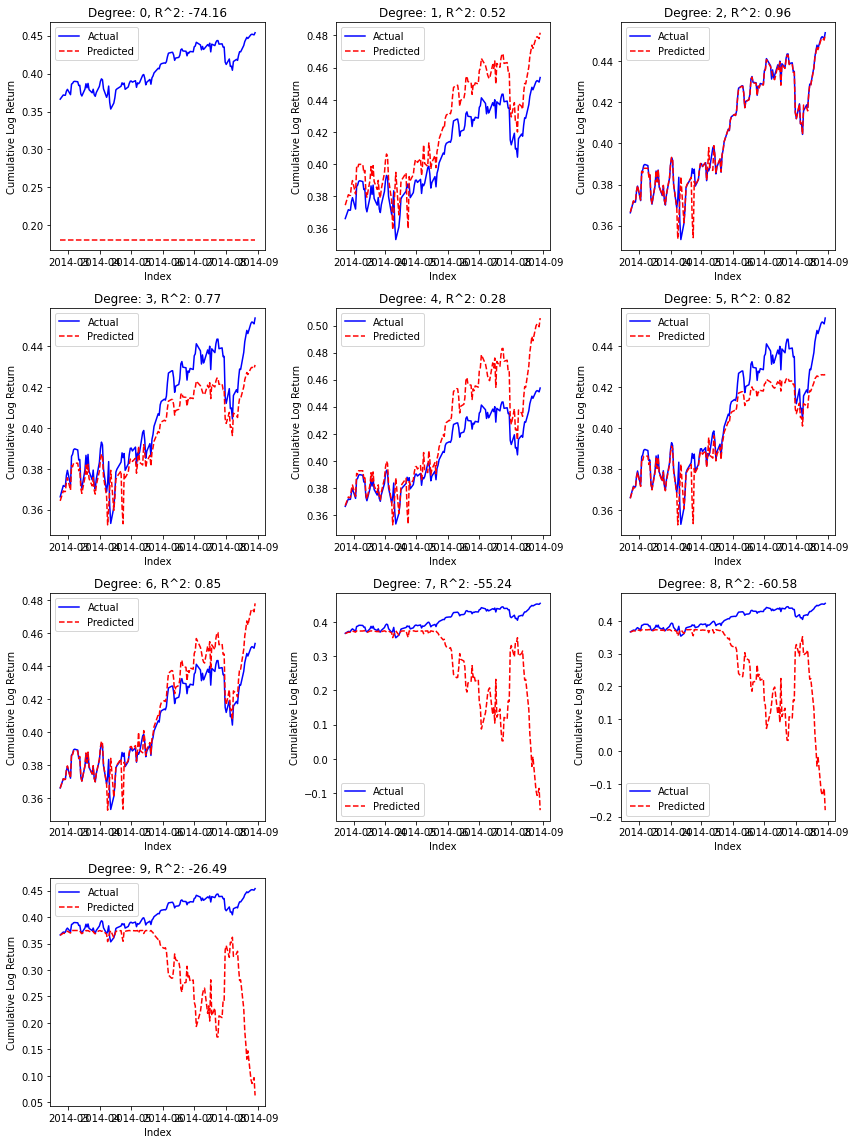

In [98]:
d = {}
n_degrees=10
n_cols = 3  # Set your desired number of columns for subplots
n_rows = (n_degrees + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over the range of polynomial degrees
for i in range(n_degrees):
    # Fetch regression data
    X_train, X_test, y_train, y_test = regression_data(df, 'Signal', 'Cumulative_Log_Return', 0.2, [5])
    # Calculate R^2 and predictions with poly_regression
    r2, predictions = poly_regression(X_train, X_test, y_train, y_test, i, False)
    # Store the R^2 value in the dictionary using degree as the key
    d[i] = r2

    # Plot actual vs. predicted values using the correct axes index
    ax = axes[i]  # Use 'i' as the index for the current subplot
    ax.plot(y_test.index, y_test, label='Actual', color='blue')
    ax.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--')
    # Set the title for the subplot with the R^2 value
    ax.set_title(f'Degree: {i}, R^2: {r2:.2f}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Cumulative Log Return')
    ax.legend()
    
for j in range(i + 1, n_rows * n_cols):  # This assumes 'i' is still set to the last used subplot index after the loop
    axes[j].set_visible(False)


# Sort the dictionary by R-squared values in descending order and print
sorted_degree = sorted(d.items(), key=lambda item: item[1], reverse=True)
print('Sorted degrees by R2-score:', sorted_degree)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

=> The incorporation of polynomial regression into our analysis has yielded a substantial improvement in the R^2 score over the simpler Ordinary Least Squares (OLS) regression model. The polynomial model captures more of the variance in the cumulative log returns.

In [99]:
r=[]
for i in range(10):
    d={}
    for idx, combination in enumerate(all_combinations):
        X_train, X_test, y_train, y_test = regression_data(df, 'Signal', 'Cumulative_Log_Return', 0.2, combination)
        r2,predictions = poly_regression(X_train, X_test, y_train, y_test,i,False)
        d[tuple(combination)]=r2
    # Sort the dictionary by R-squared values in descending order
    sorted_combinations = sorted(d.items(), key=lambda item: item[1],reverse=True)
    r.append([sorted_combinations[0][0],sorted_combinations[0][1],i])
# After your for loop which appends data to r
sorted_r = sorted(r, key=lambda x: x[1], reverse=True)  # Sorting by R-squared values in descending order

# Print the sorted list
print('Sorted_combinations by R2-score : ',sorted_r)


Sorted_combinations by R2-score :  [[(5,), 0.9582417964783172, 2], [(2, 4, 5), 0.9530984345391583, 3], [(2, 3, 5), 0.900001920261202, 4], [(5,), 0.8452003088085006, 6], [(5,), 0.821904918912589, 5], [(5,), 0.521652280226472, 1], [(2, 3), -2.0923352119266245, 7], [(2,), -4.230713698961877, 8], [(3,), -8.063846583857213, 9], [(5,), -74.15809803193956, 0]]


=> After thorough testing across various combinations and model complexities, it has been determined that the model offering the most accurate predictions for our data is a second-degree polynomial regression. Notably, this model performs best when it incorporates a 5-days shifted signal.


=>The efficiency of this approach is underscored by an impressive R2 score of 0.9582, suggesting a predictive accuracy that is significantly close to actual observed values.

R^2 Score: 0.9582417964783172


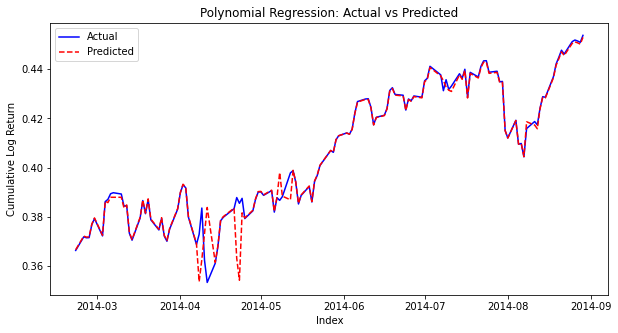

In [100]:
X_train, X_test, y_train, y_test = regression_data(df, 'Signal', 'Cumulative_Log_Return', 0.2, [5])
r2,predictions = poly_regression(X_train, X_test, y_train, y_test,2,True)


=> The graph confirms the conclusions above.

##### Testing the model with more training data

R^2 Score: 0.9954653308957085


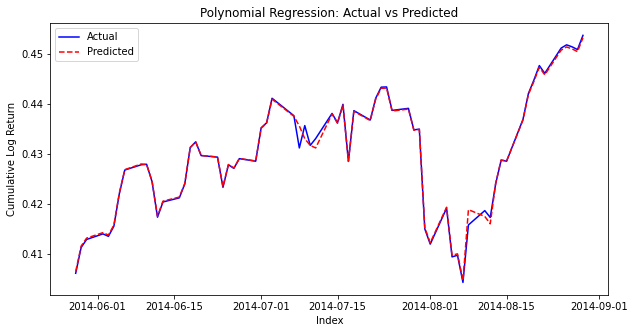

In [101]:
X_train, X_test, y_train, y_test = regression_data(df, 'Signal', 'Cumulative_Log_Return', 0.1, [5])
r2,predictions = poly_regression(X_train, X_test, y_train, y_test,2,True)

=> When adding more training data (split ration of 0.1 instead of 0.2) we can see the R2 score is almost equal to 1 and the shifted signal explains almots 100% of the variance of cumulative log returns of the price of S&P index.

### Testing of overfitting with a walk forward

c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


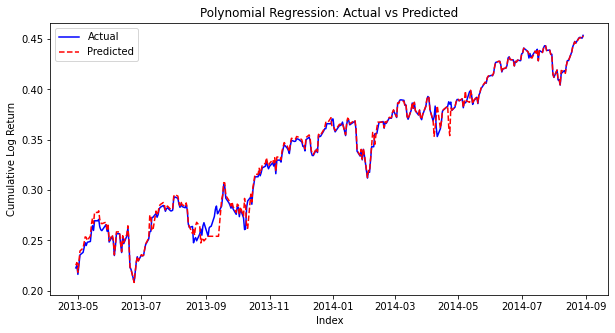

 R-squared scores :  [0.8669758507183515, 0.9889720668364448, 0.906488520379048, 0.8697801213709455, -0.04343983872213997, -0.25360089742274683, 0.8438336289417383, 0.8486963962316117, 0.8854887061125847, 0.9676180569529429, 0.8818060830581473, 0.9975676175644986, -0.5815023167800348, 0.881472855816445, 0.99964950593851, 0.9599979418605431, 0.997386737857479, nan]


In [102]:
_, X, _, y = regression_data(df, 'Signal', 'Cumulative_Log_Return',1, [5])

def walk_forward_analysis(X, Y, split_point, poly_degree):
    total_size = len(X)
    r2_scores = []
    all_predictions = []
    test=[]
    indice=[]

    for start in range(300, total_size - split_point, 20):
        end = start + split_point if start + split_point < total_size else total_size
        X_train_wf = X[:end]
        y_train_wf = Y[:end]
        X_test_wf = X[end:end + split_point]
        y_test_wf = Y[end:end + split_point]
        
        r2_score, predictions = poly_regression(X_train_wf, X_test_wf, y_train_wf, y_test_wf, poly_degree, False)
        r2_scores.append(r2_score)
        all_predictions.extend(predictions)
        test.extend(y_test_wf)
        indice.extend(y_test_wf.index)
        if end + split_point >= total_size:
            break

    return r2_scores, all_predictions,test,indice

# Assuming 'X' and 'y' are defined and properly prepared for regression analysis
r, predictions,test,indice = walk_forward_analysis(X, y, 20, 2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(indice, test, label='Actual', color='blue')  # Adjust the index slicing accordingly
plt.plot(indice, predictions, label='Predicted', color='red', linestyle='--')  # Adjust the index slicing accordingly
plt.title('Polynomial Regression: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.show()

# Print R-squared scores
print(' R-squared scores : ' ,r)




=> The walk-forward method, when applied to test for overfitting, has yielded promising outcomes. The model's predictions of cumulative log returns closely align with the actual returns across nearly all testing intervals, suggesting a consistent performance. This consistency indicates that the model exhibits a high degree of robustness and is not prone to overfitting. It appears to generalize well to new data, maintaining its predictive power outside the in-sample data used for training.

#### Testing the model with unclean data

R^2 Score: -39.10917220707141


C:\Users\MSI\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


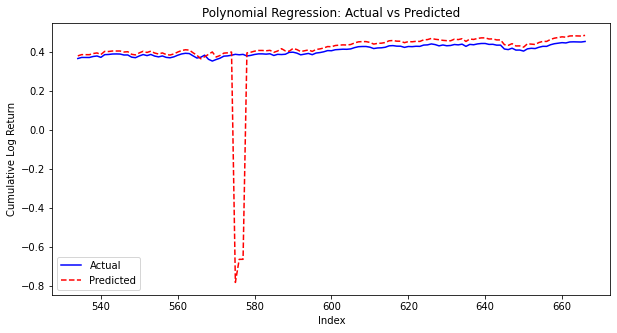

In [103]:
# Calculation of simple returns for ClosePrice
data['Cumulative_Return'] = (data['ClosePrice'].pct_change()).cumsum()
# Calculation of simple returns for Signal
data['Return'] = data['ClosePrice'].pct_change()
# Calculation of logarithmic returns for ClosePrice
data['Cumulative_Log_Return'] = (np.log(data['ClosePrice'] / data['ClosePrice'].shift(1))).cumsum()
# Calculation of logarithmic returns for Signal
data['Log_Return'] = np.log(data['Signal'] / data['Signal'].shift(1))
data = data.dropna() # Drop rows with NaN value
X_train, X_test, y_train, y_test = regression_data(data, 'Signal', 'Cumulative_Log_Return', 0.2, [5])
r2,predictions = poly_regression(X_train, X_test, y_train, y_test,2,True)

=> The model is very sensitive to outliers.

### 6- Final Conclusions

Observations:

- The model appears to track the general trends in the actual data quite closely, indicating that it captures the underlying pattern effectively especially when we have a larger set of training data.

- In the initial months (March to early April), the model has some difficulty in capturing the actual values, as seen by the divergence between the actual and predicted lines. However, as time progresses, the predicted values seem to converge more consistently with the actual data.

- The model demonstrates a strong ability to predict the direction of the trend, though it seems to slightly underestimate or overestimate the values at certain points.

Shortcomings:

- The model might not be capturing potential outliers or noise effectively, which could be critical in a highly volatile market.

- It does not account for potential shifts in market conditions or external factors influencing asset prices beyond historical price movements.

Recommendations:

- Regular Updates: The model should be updated regularly with new data to ensure it adapts to the latest market conditions.
- Detection of outliers and data cleaning are crucial.
- Risk Management: Due to inherent uncertainties in any predictive model, it's crucial to pair this model's predictions with a robust risk management strategy.